In [1]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [1]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=280
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147
nipd=int((et-st)/Bin_size)-irows-orows+1

In [2]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_n&f.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_n&f.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [4]:
print(irows,orows)

3 1


In [5]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a multivariate sequence into samples and put them into X and y
X, y = list(), list()
def split_sequences(sequences, n_steps_in, n_steps_out):
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-2], sequences[end_ix:out_end_ix, :-2]
		X.append(seq_x)
		y.append(seq_y)
	return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# convert into input/output
for i in range(1,365):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    split_sequences(todays_df, n_steps_in, n_steps_out)

#Check if the io sample count is valid:
if nipd*34==len(X)==len(y):
    print("IO Matrix creation successful!")
else:
    print("IO Matrix creation unsuccessful!")

Using TensorFlow backend.


IO Matrix creation successful!


In [6]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np
X_fil=np.array(X)
y_fil=np.array(y)
del_index=[]

# Noting down the index of Na matricesin del_index 
for i in range(len(X_fil)):
    del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))

# Filtering out the Na matrices from y_fil and X_fil by indexing using a list
y_fil=y_fil[list(~np.array(del_index))]
X_fil=X_fil[list(~np.array(del_index))]

# Check if the filtering is successful:
Na_count=0
for i in range(len(X_fil)):
    if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
        Na_count=Na_count+1
if Na_count==0:
    print("Na Matrices filtered out sucessfuly!")
# y=np.array(y)
# for el in y[list(~np.array(deathlist))]:
#     print(np.any(np.isnan(Xtrial[i])))


Na Matrices filtered out sucessfuly!


In [7]:
# Normalizing the Input and output matrices.

In [8]:
# Print number of IO Pairs available:
print(len(y_fil)," I/O pairs available.")

510  I/O pairs available.


In [9]:
# Flatten output
n_output = y_fil.shape[1] * y_fil.shape[2]
y_fil = y_fil.reshape((y_fil.shape[0], n_output))

In [10]:
# Check the number of features
if n_features == X_fil.shape[2]:
    print("Good to go!")
else:
    print("Something wrong..")

Good to go!


In [11]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X_fil)) < 0.8
X_train = X_fil[msk]
y_train = y_fil[msk]
X_test = X_fil[~msk]
y_test = y_fil[~msk]
print("Dataset splitting done!")

Dataset splitting done!


In [12]:
# multivariate output multi-step 1d cnn example
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12
# fit model
history=model.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Number or epochs:",epochno)
print("Number of input features:",n_features)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available:",len(y_fil))
print("Model Mape loss:",model.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

W0716 00:02:08.435802 140466702657344 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 00:02:08.438637 140466702657344 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 00:02:08.444534 140466702657344 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 00:02:08.478255 140466702657344 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W07

Number or epochs: 12
Number of input features: 280
Number of output features: 280
Bin size: 1
Window size: 3
Number of I/O pairs available: 510
98/98 [==============================] - 0s 49us/step
Model Mape loss: 2807247.2653061226
98/98 [==============================] - 0s 80us/step
Model MSE loss (Minimized): 0.04147895159465926
98/98 [==============================] - 0s 66us/step
RMSE loss: 0.2036638200433726


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


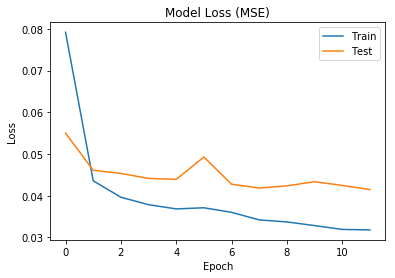

In [13]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [14]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [21]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100)

#function to get the act and pdt values of a specified sample in the test set
def get_pdt_act(ind):
    #print(ind)
    # Demonstrate Prediction
    x_input = X_test[ind]
    x_input = x_input.reshape((1, irows, n_features))
    yhat = model.predict(x_input, verbose=0)
    y_output = y_test[ind]
    #print(len(yhat[0]))
    pdt=yhat[0]
    act=y_output
    if len(pdt)!=len(act):
        print("ERROR!")
    return pdt,act
        
norm_pdt,norm_act=get_pdt_act(6)

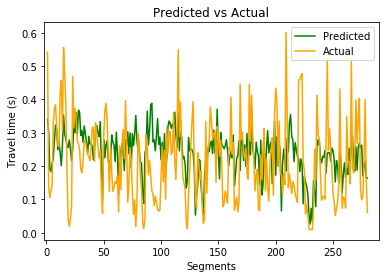

In [22]:
import matplotlib.pyplot as plt
import numpy

def plot_this(pdt_plt,act_plt):
    x=list(range(1,len(pdt)+1))
    plt.plot(x, pdt_plt[0:], color='g',label="Predicted")
    plt.plot(x, act_plt[0:], color='orange',label="Actual")
    plt.xlabel('Segments')
    plt.ylabel('Travel time (s)')
    plt.title('Predicted vs Actual')
    axes = plt.gca()
    #axes.set_ylim([0,180])
    axes.set_xlim([-2,len(pdt)+10])
    leg = plt.legend();
    plt.show()
plot_this(norm_pdt,norm_act)

In [17]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax.csv')


In [18]:
Minmax.drop(["V281"],axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280
0,144.393008,115.714823,42.493365,24.211194,20.792030,31.301400,15.261249,11.463829,10.438957,10.160103,...,16.602995,14.777967,13.615912,14.194309,13.784148,15.715016,15.611628,16.334124,23.636502,32.203997
1,21.743496,27.824041,12.590967,10.181975,9.777823,10.144633,8.673208,7.440940,6.730975,6.393548,...,6.540165,6.273787,6.223952,6.223956,6.212245,6.268387,6.356335,6.478718,6.811262,7.332060


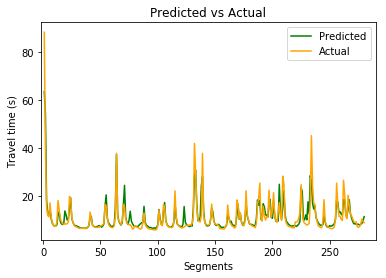

In [23]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def denormalize(nor_pdt,nor_act):
    pdt_cor=[i for i in range(280)]
    act_cor=[i for i in range(280)]
    i=0
    for col in Minmax.drop(["V281"],axis=1):
        mn=Minmax[col][1]
        mx=Minmax[col][0]
        pdt_cor[i]=(nor_pdt[i]*(mx - mn))+mn
        act_cor[i]=(nor_act[i]*(mx - mn))+mn
        i=i+1
    return pdt_cor,act_cor

denorm_pdt,denorm_act=denormalize(norm_pdt,norm_act)    
plot_this(denorm_pdt,denorm_act)

In [24]:
import matplotlib.pyplot as plt
import numpy

#function to get errror for any pdt and act
def get_error_pdt_act(pdt_err,act_err,printing=False):
    if printing==True:
        print("MSE Error:",mean_squared_error(pdt_err,act_err))
        print("RMSE Error:",np.sqrt(mean_squared_error(pdt_err,act_err)))
        print("MAPE Error:",mean_absolute_percentage_error(pdt_err,act_err))
    mse=mean_squared_error(pdt_err,act_err)
    rmse=np.sqrt(mean_squared_error(pdt_err,act_err))
    mape=mean_absolute_percentage_error(pdt_err,act_err)
    return mse,rmse,mape

get_error_pdt_act(denorm_pdt,denorm_act,False) 
print("MSE Error:",mean_squared_error(act_cor,pdt_cor))
print("RMSE Error:",np.sqrt(mean_squared_error(act_cor,pdt_cor)))
print("MAPE Error:",mean_absolute_percentage_error(act_cor,pdt_cor))


MSE Error: 31.143683340294682
RMSE Error: 5.580652590897832
MAPE Error: 12.506919784081546


In [27]:
#Iterating over all tensors in test set
#Check if lengths match:
if X_test.shape[0]==y_test.shape[0]:
    print("Good to go!")
else:
    print("Lengths dont match!")

MSE_list=[]
RMSE_list=[]
MAPE_list=[]

total_test=X_test.shape[0]
for ind in range(total_test):
    norm_pdt,norm_act=get_pdt_act(ind)
    denorm_pdt,denorm_act=denormalize(norm_pdt,norm_act)
    MSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[0])
    RMSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[1])
    MAPE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[2])

mean_MSE=sum(MSE_list)/len(MSE_list)
mean_RMSE=sum(RMSE_list)/len(RMSE_list)
mean_MAPE=sum(MAPE_list)/len(MAPE_list)    

print("\n")
print("Model - 1")
print("Overall MSE",mean_MSE)
print("Overall RMSE",mean_RMSE)
print("Overall MAPE",mean_MAPE)

Good to go!


Model - 1
Overall MSE 44.838343676217065
Overall RMSE 6.290657742340175
Overall MAPE 17.97336535771105
